![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de bicicletas durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip), [dicccionario de datos](https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset#).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [59]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [5]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)

# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)

# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour

# Visualización de los datos
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables "season" y "hour", escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [8]:
# Celda 1.1
bikes.groupby('season').total.mean()

season
1    116.343261
2    215.251372
3    234.417124
4    198.988296
Name: total, dtype: float64

In [10]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica del número de bicicletas rentadas promedio para cada valor de la variable "hour" (hora) cuando la variable "season" es igual a 1 (invierno) e igual a 3 (verano), respectivamente. Analice y escriba sus hallazgos.

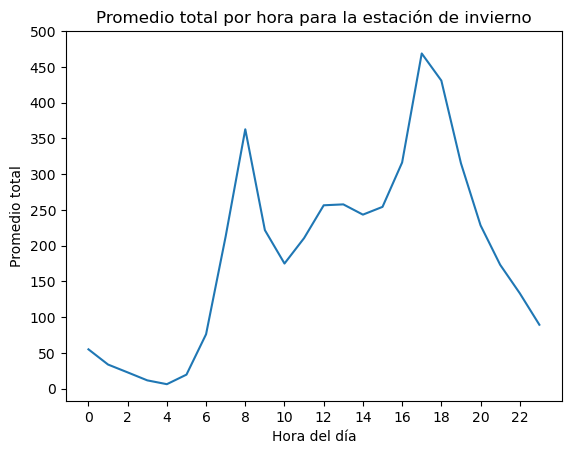

In [13]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

# Importo la libreria para graficar
import matplotlib.pyplot as plt

plt.xlabel('Hora del día')
plt.xticks(np.arange(0,24,2))
plt.ylabel('Promedio total')
plt.yticks(np.arange(0,550,50))
plt.title('Promedio total por hora para la estación de invierno')
plt.show()

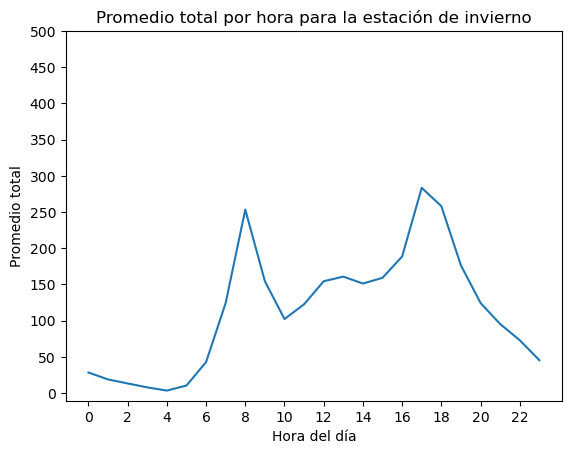

In [15]:
# Celda 2.2 - "season"=1 escriba su código y hallazgos 

# Filtro la columna de season == 1
bikes_season_1 = bikes[(bikes["season"] == 1)]

# Calculo el promedio hora a hora para la estacion de invierno 
bikes_season_1.groupby("hour").total.mean().plot()

# Grafico los promedios hora a hora
plt.xlabel('Hora del día')
plt.xticks(np.arange(0,24,2))
plt.ylabel('Promedio total')
plt.yticks(np.arange(0,550,50))
plt.title('Promedio total por hora para la estación de invierno')
plt.show()

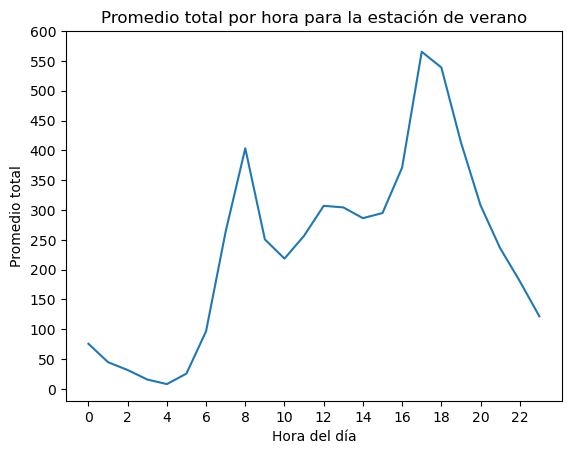

In [17]:
# Celda 2.3 - "season"=3 escriba su código y hallazgos 
bikes_season_3 = bikes[(bikes["season"] == 3)]

# Calculo el promedio hora a hora para la estacion de invierno 
bikes_season_3.groupby("hour").total.mean().plot()

# Grafico los promedios hora a hora
plt.xlabel('Hora del día')
plt.xticks(np.arange(0,24,2))
plt.ylabel('Promedio total')
plt.yticks(np.arange(0,650,50))
plt.title('Promedio total por hora para la estación de verano')
plt.show()

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a un conjunto de train de datos, utilizando "total" como variable de respuesta y "season" y "hour" como las únicas variables predictoras, teniendo en cuenta que la variable "season" es categórica. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [63]:
# Celda 3

# Como la variable "season" es categorica y no es una variable ordinal, procedo a convertirlas en variables dummies
bikes_with_dummies = pd.get_dummies(bikes, columns=['season'], drop_first= True)

# Selecciono las variables predictoras y la variable de respuesta
X = bikes_with_dummies[['season_2', 'season_3', 'season_4', 'hour']]
y = bikes_with_dummies["total"]

# Hago la particion de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1111)

# Ajusto y entreno el modelo de regresion
lr = LinearRegression()
lr.fit(X_train, y_train)

# Hago predicciones
pred = lr.predict(X_test)

# Evaluo el modelo
mse = mean_squared_error(y_test, pred)
rmse = mse**0.5
r2 = r2_score(y_test, pred)

# Resultados
print("El MSE es igual a: " + str(mse))
print("El RMSE es igual a: " + str(rmse))
print("El R2 es igual a:" + str(r2))
print("Los coeficientes del modelo son: " + str(lr.coef_))

El MSE es igual a: 26064.63214266029
El RMSE es igual a: 161.44544633609303
El R2 es igual a:0.21753594949018062
Los coeficientes del modelo son: [100.67957813 118.55016127  81.21016105  10.63244176]


### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "season". El árbol debe tener al menos 6 nodos finales.

In [71]:
# Celda 4

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "season" y "hour" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Recuerde dividir los datos en conjuntos de entrenamiento y validación para esto. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

In [83]:
# Celda 5

# Importo libreria para calibración
from sklearn.model_selection import GridSearchCV

# Voy a utilizar el dataframe "bikes" definido desde un inicio
# En este ejercicio no haré uso de las variables dummies (No es estrictamente necesario en arboles de decisiones)

# Defino mis variables predictoras y la variable de respuesta 
X = bikes[["season", "hour"]]
y = bikes["total"]

# Hago la particion de train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1111)

# Voy a calibrar el árbol pre poda con gridsearch. Calibraré el hiperpárametro de maxdepth

# Defino los valores posibles de maxdepth
grid_parametros = {"max_depth": [2, 4, 6, 8]}

# Creo el modelo
td = DecisionTreeRegressor(random_state = 42)

# Realizo la busqueda en el grid 
busqueda_grid = GridSearchCV(estimator = td, param_grid = grid_parametros, cv = 5, scoring = 'neg_mean_squared_error')

# Ajusto el modelo con train
busqueda_grid.fit(X_train, y_train)

# Mejor párametro
mejor_parametro = busqueda_grid.best_params_
print("Los mejores párametros encontrados son: " + str(mejor_parametro))

# Árbol con mejor parametro
mejor_modelo = busqueda_grid.best_estimator_

# Evaluo el modelo
predicciones = mejor_modelo.predict(X_test)

# Calculo MSE y R2
mse = mean_squared_error(y_test, predicciones)
r2 = r2_score(y_test, predicciones)

# Imprimo los resultados 
print("El MSE es igual a: " + str(mse))
print("El R2 es igual a:" + str(r2))



Los mejores párametros encontrados son: {'max_depth': 8}
El MSE es igual a: 13478.705690112107
El R2 es igual a:0.5953672934193028


## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la popularidad está dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el siguiente enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [ ]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/davidzarruk/MIAD_ML_NLP_2023/main/datasets/mashable.csv', index_col=0)
df.head()

In [ ]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

In [ ]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [ ]:
# Celda 6


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged donde:

-las primeras 100 muestras vienen de árboles de decisión donde max_depth tome un valor de su elección\
-las segundas 100 muestras vienen de árboles de decisión donde min_samples_leaf tome un valor de su elección\
-las últimas 100 muestras vienen de regresiones logísticas

Evalúe cada uno de los tres modelos de manera independiente utilizando las métricas de Accuracy y F1-Score, luego evalúe el ensamble de modelos y compare los resultados. 

Nota: 

Para este ensamble de 300 modelos, deben hacer votación mayoritaria. Esto lo pueden hacer de distintas maneras. La más "fácil" es haciendo la votación "manualmente", como se hace a partir del minuto 5:45 del video de Ejemplo práctico de emsablajes en Coursera. Digo que es la más fácil porque si hacen la votación mayoritaria sobre las 300 predicciones van a obtener lo que se espera.

Otra opción es: para cada uno de los 3 tipos de modelos, entrenar un ensamble de 100 modelos cada uno. Predecir para cada uno de esos tres ensambles y luego predecir como un ensamble de los 3 ensambles. La cuestión es que la votación mayoritaria al usar los 3 ensambles no necesariamente va a generar el mismo resultado que si hacen la votación mayoritaria directamente sobre los 300 modelos. Entonces, para los que quieran hacer esto, deben hacer ese último cálculo con cuidado.

Para los que quieran hacerlo como ensamble de ensambles, digo que se debe hacer el ensamble final con cuidado por lo siguiente. Supongamos que:

* para los 100 árboles del primer tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para los 100 árboles del segundo tipo, la votación mayoritaria es: 55% de los modelos predicen que la clase de una observación es "1"
* para las 100 regresiones logísticas, la votación mayoritaria es: 10% de los modelos predicen que la clase de una observación es "1"

Si se hace la votación mayoritaria de los 300 modelos, la predicción de esa observación debería ser: (100*55%+100*55%+100*10%)/300 = 40% de los modelos votan porque la predicción debería ser "1". Es decir, la predicción del ensamble es "0" (dado que menos del 50% de modelos predijo un 1).

Sin embargo, si miramos cada ensamble por separado, el primer ensamble predice "1", el segundo ensamble predice "1" y el último ensamble predice "0". Si hago votación mayoritaria sobre esto, la predicción va a ser "1", lo cual es distinto a si se hace la votación mayoritaria sobre los 300 modelos.

In [ ]:
# Celda 7


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [ ]:
# Celda 8


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [ ]:
# Celda 9